# Training RNN models to predict charging demand at an EV charging station

Click in the link to open this notebook on Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

## Setup
#### Clone repo and set current working directory 
(Only run this cell if you are working in the cloud (Colab), otherwise, it is not neccesary)

In [1]:
!git clone https://github.com/curroramos/EV_Charging_Load_Prediction.git
%cd EV_Charging_Load_Prediction/  
#%pip install -qr requirements.txt  # install
%pwd

Cloning into 'EV_Charging_Load_Prediction'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (373/373), done.
remote: Compressing objects: 100% (330/330), done.
remote: Total 373 (delta 95), reused 311 (delta 41), pack-reused 0
Receiving objects: 100% (373/373), 27.57 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/EV_Charging_Load_Prediction


'/content/EV_Charging_Load_Prediction'

#### Import packages

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from plot_utils import plot_series
from data_handler import load_dataset

In [4]:
# Plot settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)
pd.options.plotting.backend = "plotly"

## 1. Load and prepare the dataset

In [5]:
dataset = "ACN_data"

series,times = load_dataset(dataset)

#### Plot some data

<Figure size 720x432 with 0 Axes>

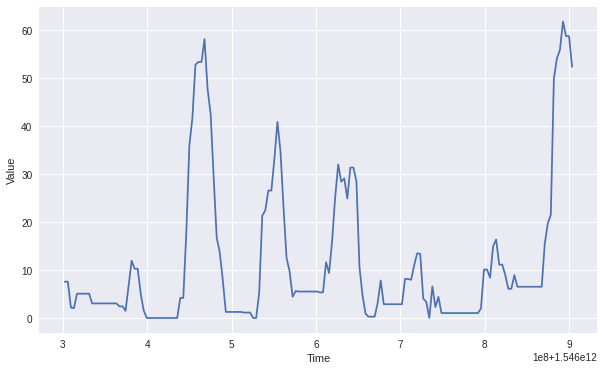

In [6]:
plt.figure(figsize=(10, 6))
plot_series(times,
            series,
            start=0,
            end = 24 * 7)  # with this, we can select a frame to plot

#### Normalize the dataset

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0.1, 1)) #Also try QuantileTransformer
series_scaled = scaler.fit_transform(series)

#### Split training and validation sets

In [8]:
split_time = int(len(times) * 0.66)

time_train = times[:split_time]
x_train = series[:split_time] # No scaled
x_train_scaled = series_scaled[:split_time]

time_test = times[split_time:]
x_test = series[split_time:] # No scaled
x_test_scaled = series_scaled[split_time:]


#### Create the data generators for training

In [9]:
window_size = 24 * 4 # 4 days
num_features = 1

batch_size = 16 # For training

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

train_generator = TimeseriesGenerator(x_train_scaled,
                                      x_train_scaled,
                                      length=window_size,
                                      batch_size=batch_size)

validation_generator = TimeseriesGenerator(x_test_scaled,
                                           x_test_scaled,
                                           length=window_size,
                                           batch_size=batch_size)

In [11]:
# Plot an input sequence and its true output
x, y = train_generator[0]
print("Input:",x,"Output:",y)

Input: [[[0.21015621]
  [0.21015621]
  [0.13186532]
  ...
  [0.46277379]
  [0.55659306]
  [0.55659306]]

 [[0.21015621]
  [0.13186532]
  [0.12957217]
  ...
  [0.55659306]
  [0.55659306]
  [0.51551834]]

 [[0.13186532]
  [0.12957217]
  [0.17378388]
  ...
  [0.55659306]
  [0.51551834]
  [0.25512326]]

 ...

 [[0.14421172]
  [0.14421172]
  [0.14421172]
  ...
  [0.14172032]
  [0.14172032]
  [0.14172032]]

 [[0.14421172]
  [0.14421172]
  [0.14421172]
  ...
  [0.14172032]
  [0.14172032]
  [0.14172032]]

 [[0.14421172]
  [0.14421172]
  [0.14421172]
  ...
  [0.14172032]
  [0.14172032]
  [0.14172032]]] Output: [[0.51551834]
 [0.25512326]
 [0.1696006 ]
 [0.11284674]
 [0.10402456]
 [0.10402456]
 [0.10402456]
 [0.14574489]
 [0.21385825]
 [0.14172032]
 [0.14172032]
 [0.14172032]
 [0.14172032]
 [0.14172032]
 [0.14172032]
 [0.14172032]]


## 2. Build the model

#### Build the model
##### Models selected can be:
- Simple_ANN
- Simpler_RNN
- Simple_RNN
- LSTM
- LSTM_stacked
- Bidirectional_LSTM
- CNN_LSTM

In [12]:
from model_utils import build_model

model_name = "CNN_LSTM"

model = build_model(model_name,
                   window_size,
                   num_features)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 96, 32)            192       
                                                                 
 lstm (LSTM)                 (None, 96, 64)            24832     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 60,319
Trainable params: 60,319
Non-traina

## 3.a Train the model

#### Delete previous session

In [14]:
tf.keras.backend.clear_session()
# To obtain constant results
tf.random.set_seed(51)
np.random.seed(51)

#### Configure callbacks

In [15]:
from model_utils import configure_callbacks

callbacks = configure_callbacks(early_stopping = True,patience=100, checkpoint= False, model_name= model_name )

#### Compilate the model

In [16]:
optimizer = 'adam'
metrics = ['acc']

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=metrics)

#### Train the model

In [17]:
epochs = 30
history = model.fit_generator(generator=train_generator,
                              verbose=1,
                              epochs=epochs,
                              validation_data=validation_generator,
                              callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
335/335 [==============================] - 33s 87ms/step - loss: 0.0110 - acc: 0.0000e+00 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 2/30
335/335 [==============================] - 26s 77ms/step - loss: 0.0042 - acc: 1.8685e-04 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 3/30
335/335 [==============================] - 25s 76ms/step - loss: 0.0034 - acc: 1.8685e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 4/30
335/335 [==============================] - 26s 77ms/step - loss: 0.0027 - acc: 1.8685e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 5/30
335/335 [==============================] - 26s 77ms/step - loss: 0.0023 - acc: 1.8685e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 6/30
335/335 [==============================] - 25s 76ms/step - loss: 0.0022 - acc: 1.8685e-04 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 7/30
335/335 [==============================] - 26s 76ms/step - loss: 0.0021 - acc: 1.8685e-04 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 

#### Plot the training and validation accuracy and loss at each epoch

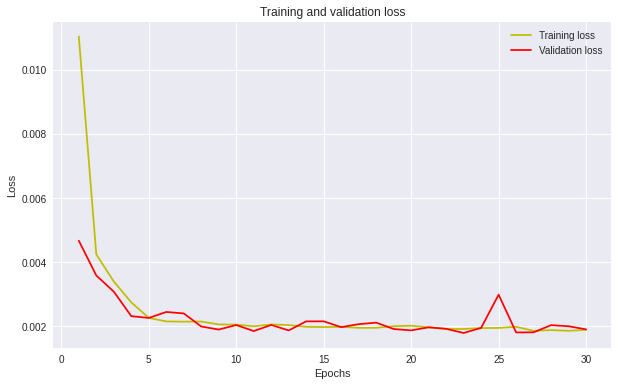

In [18]:
from plot_utils import plot_training

plot_training(history)

## 3.b Load a model

In [28]:
window_size = 96
model_name = 'CNN_LSTM'

model = tf.keras.models.load_model(f'Results/train_{model_name}_ws{window_size}_epochs30_results/{model_name}_ws{window_size}_epochs30_model.h5')

## 4. Run inferences on training and validation set

In [29]:
from model_utils import predict

train_predict = predict(model,
                        train_generator,
                        scaler)

test_predict = predict(model,
                       validation_generator,
                       scaler)

#### Validate the model using RMSE

In [30]:
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(x_train[window_size:], train_predict[:,0]))
testScore = math.sqrt(mean_squared_error(x_test[window_size:], test_predict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.17 RMSE
Test Score: 4.23 RMSE


#### Plot train and test predictions

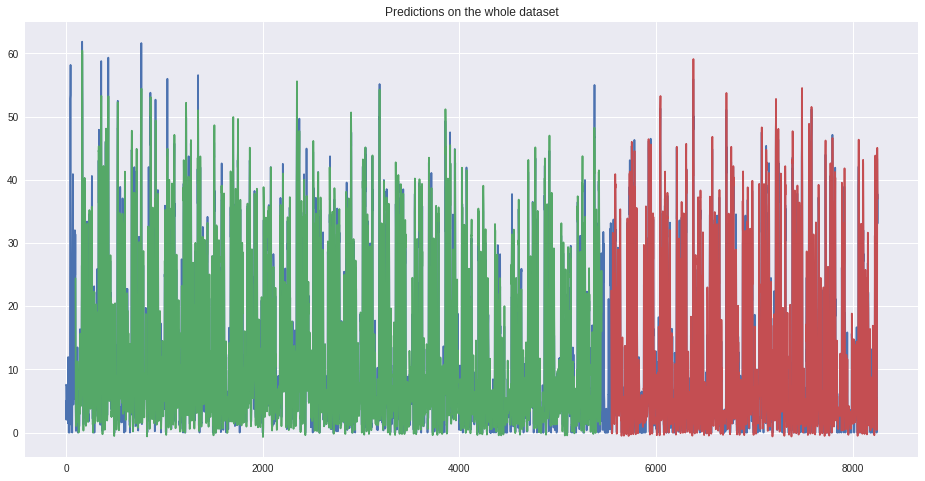

In [31]:
from plot_utils import plot_predictions

plot_predictions(train_predict,
                  test_predict,
                  window_size,
                  times,
                  series,
                  x_train)

Plot train and test predictions separately

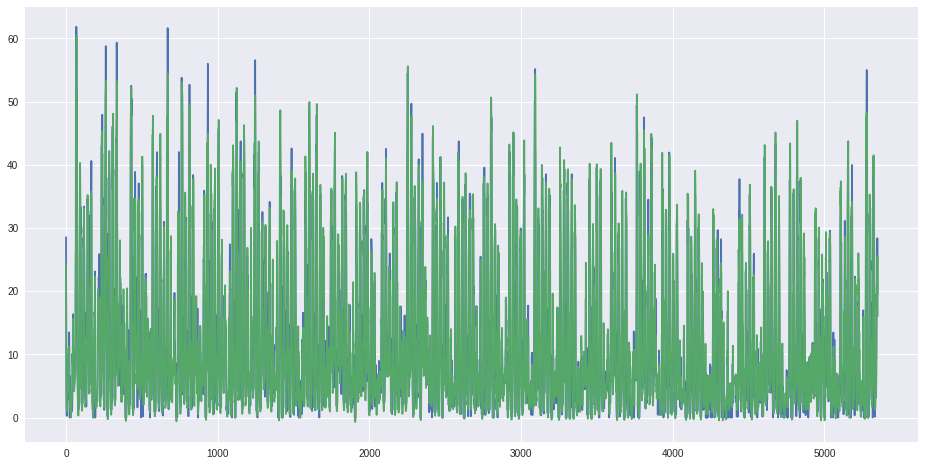

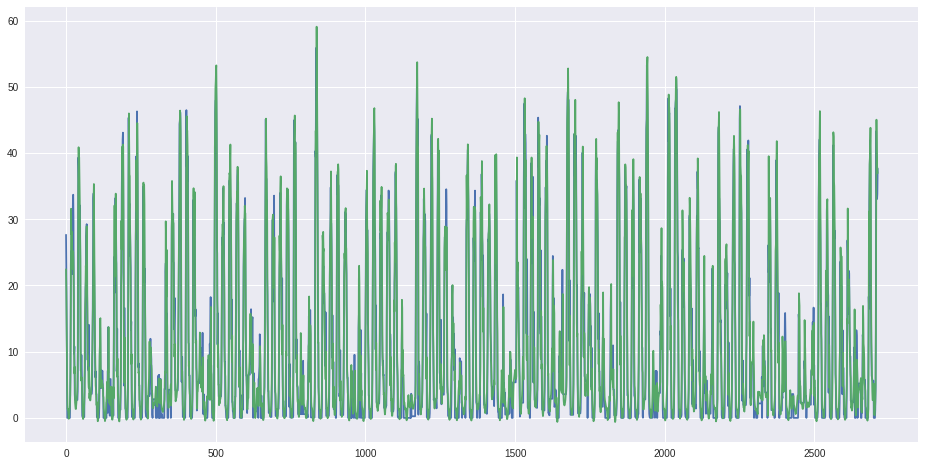

In [32]:
plt.figure()
plt.plot(x_train[window_size:])
plt.plot(train_predict[:,0])

plt.figure()
plt.plot(x_test[window_size:])
plt.plot(test_predict[:,0])

#### Plot train and test with zoom

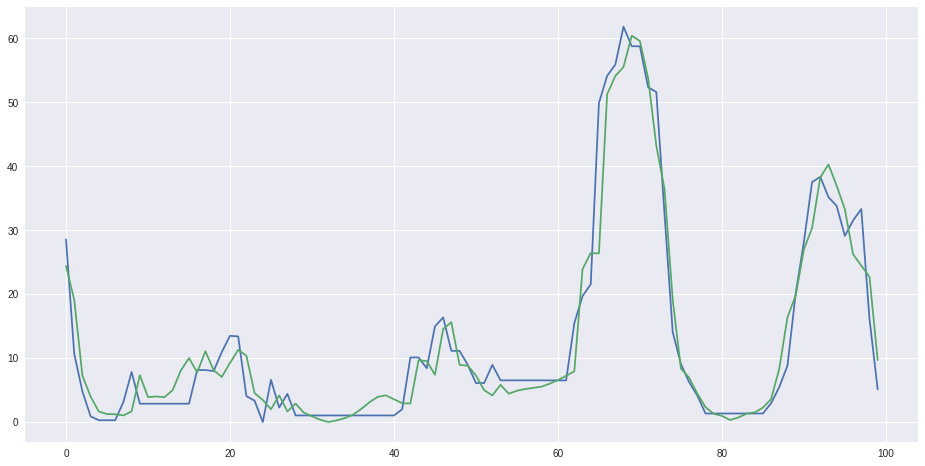

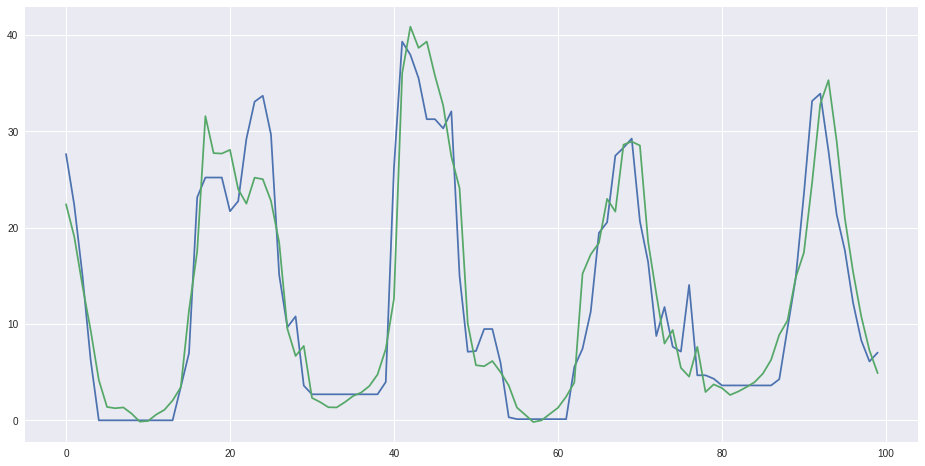

In [33]:
from plot_utils import plot_gtruth_and_predictions

# Train
start = 0
end = 100
plot_gtruth_and_predictions(x_train, train_predict, window_size, start, end)

# Test
start = 0 # 0 to len(test_predict)-1
end = 100 # 1 to len(test_predict)
plot_gtruth_and_predictions(x_test, test_predict, window_size, start, end)

## 4. Forecast first values in test using last trainig data

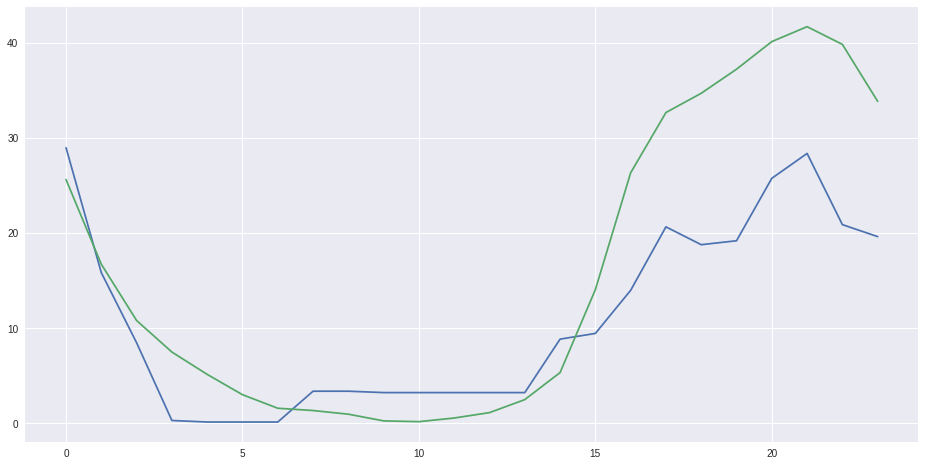

In [34]:
# Input: sequence of values (length = seq_size = 24)
prediction = [] #Empty list to populate later with predictions

current_batch = x_train_scaled[- window_size - 24 : -24] #Final data points in train 
current_batch = current_batch.reshape(1, window_size, num_features) #Reshape

# Predict future, beyond train dates
future = 24 #Samples
for i in range(future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)
 
plt.figure()
plt.plot(series[len(x_train) - 24 : len(x_train) -24 +future])
plt.plot(rescaled_prediction)
plt.show()